# Facies classification using Convolutional Neural Networks #
## Team StoDIG  - Statoil Deep-learning Interest Group ##
### _[Eskil Kulseth Dahl](https://www.linkedin.com/in/eskil-k-dahl-87a94679), [David Wade](https://no.linkedin.com/in/david-wade-79918023) & [John Thurmond](https://www.linkedin.com/in/john-thurmond-098b774)_###

In this python notebook we propose a facies classification model, building on the simple Neural Network solution proposed by LA_Team in order to outperform the prediction model proposed in the [predicting facies from well logs challenge](https://github.com/seg/2016-ml-contest). 

Given the limited size of the training data set, Deep Learning is not likely to exceed the accuracy of results from refined Machine Learning techniques (such as Gradient Boosted Trees).  However, we chose to use the opportunity to advance our understanding of Deep Learning network design, and have enjoyed participating in the contest.  With a substantially larger training set and perhaps more facies ambiguity, Deep Learning could be a preferred approach to this sort of problem.


We use three key innovations:
 - Inserting a convolutional layer as the first layer in the Neural Network
 - A convolution layer, a stack of LSTMs (with skip connection) feeding a Maxout layer cf. [CLDNN](research.google.com/pubs/archive/43455.pdf) & [Maxout](https://arxiv.org/pdf/1302.4389v4.pdf)
 - Adding Dropout regularization to prevent overfitting

## Problem Modeling
----

The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a classifier to predict facies types. 

This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

## Setup
---

Check we have all the libraries we need, and import the modules we require. Note that we have used the Theano backend for Keras, and to achieve a reasonable training time we have used an NVidia K20 GPU.

In [ ]:
%%sh
pip install pandas
pip install scikit-learn
pip install keras
pip install sklearn

In [1]:
from __future__ import print_function
import time
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.constraints import maxnorm, nonneg
from keras.optimizers import SGD, Adam, Adamax, Nadam
from keras.regularizers import l1, l2, activity_l2
from keras.layers import Input, Dense, Dropout, Activation, LSTM, GRU, Reshape, MaxoutDense, Convolution1D, Cropping1D, Cropping2D, Permute, Flatten, MaxPooling1D, merge
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
from classification_utilities import display_cm, display_adj_cm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

Using Theano backend.
ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


## Data ingest
---
We load the training and testing data to preprocess it for further analysis, filling the missing data values in the PE field with zero and proceeding to normalize the data that will be fed into our model. We now incorporate the Imputation from Paolo Bestagini via LA_Team's Submission 5.

In [2]:
data = pd.read_csv('train_test_data.csv')

# Set 'Well Name' and 'Formation' fields as categories
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')

def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

data['Formation_coded'] = coding(data['Formation'], {'A1 LM':1,'A1 SH':2,'B1 LM':3,'B1 SH':4,'B2 LM':5,'B2 SH':6,'B3 LM':7,'B3 SH':8,'B4 LM':9,'B4 SH':10,'B5 LM':11,'B5 SH':12,'C LM':13,'C SH':14})
formation = data['Formation_coded'].values[:,np.newaxis]

# Parameters
feature_names = ['Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
well_names_test = ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
well_names_validate = ['STUART', 'CRAWFORD']

data_vectors = data[feature_names].values
correct_facies_labels = data['Facies'].values

well_labels = data[['Well Name', 'Facies']].values
depth = data['Depth'].values

# Fill missing values and normalize for 'PE' field
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data_vectors)
data_vectors = imp.transform(data_vectors)

data_vectors = np.hstack([data_vectors, formation])

scaler = preprocessing.StandardScaler().fit(data_vectors)
scaled_features = scaler.transform(data_vectors)
data_out = np.hstack([well_labels, scaled_features])
print(data_out[0:2,2:11].shape)

(2, 9)


Split data into training data and blind data, and output as Numpy arrays

In [3]:
def preprocess(data_out):
    
    data = data_out
      
    X = data[0:4149,0:11]
    
    y = np.concatenate((data[0:4149,0].reshape(4149,1), np_utils.to_categorical(correct_facies_labels[0:4149]-1)), axis=1)
    X_test = data[4149:,0:11]

    return X, y, X_test

X_train_in, y_train, X_test_in = preprocess(data_out)

print(y_train.shape)
print(X_train_in.shape)

(4149, 10)
(4149, 11)


## Data Augmentation
---

We expand the input data to be acted on by the convolutional layer.

In [4]:
conv_domain = 7

# Reproducibility
np.random.seed(7) 
# Load data

def expand_dims(input):
    r = int((conv_domain-1)/2)
    l = input.shape[0]
    n_input_vars = input.shape[1]
    output = np.zeros((l, conv_domain, n_input_vars))
    for i in range(l):
        for j in range(conv_domain):
            for k in range(n_input_vars):
                output[i,j,k] = input[min(i+j-r,l-1),k]
    return output

X_train = np.empty((0,conv_domain,9), dtype=float)
X_test  = np.empty((0,conv_domain,9), dtype=float)
y_select = np.empty((0,9), dtype=int)

well_names_train = ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'NEWBY', 'CHURCHMAN BIBLE']

for wellId in well_names_train:
    X_train_subset = X_train_in[X_train_in[:, 0] == wellId][:,2:11]
    X_train_subset = expand_dims(X_train_subset)
    X_train = np.concatenate((X_train,X_train_subset),axis=0)
    y_select = np.concatenate((y_select, y_train[y_train[:, 0] == wellId][:,1:10]), axis=0)
    
for wellId in well_names_validate:
    X_test_subset = X_test_in[X_test_in[:, 0] == wellId][:,2:11]
    X_test_subset = expand_dims(X_test_subset)
    X_test = np.concatenate((X_test,X_test_subset),axis=0)

y_train = y_select
    
print(X_train.shape)
print(X_test.shape)
print(y_select.shape)

(4069, 7, 9)
(830, 7, 9)
(4069, 9)


### Convolutional Long-Short term Memory Fully connected Neural Network
#### We build a CLDNN with the following layers (no longer using Sequential() model):

 - Dropout layer on input
 - One 1D convolutional layer (7-point radius) feeding the LSTM stack and skipping to the Maxout layer
 - One 1D cropping layer (just take actual log-value of interest), feeding the LSTM branch
 - A Merge layer re-adding result of LSTM stack and the result from the convolution layer
 - L1 regularization is applied to the Convolution filter to avoid noisy kernels.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 7, 9)          0                                            
____________________________________________________________________________________________________
Dropout_Conv_1 (Dropout)         (None, 7, 9)          0           Input[0][0]                      
____________________________________________________________________________________________________
Conv1D_1 (Convolution1D)         (None, 7, 63)         4032        Dropout_Conv_1[0][0]             
____________________________________________________________________________________________________
Dropout_Conv_Dense (Dropout)     (None, 7, 63)         0           Conv1D_1[0][0]                   
___________________________________________________________________________________________

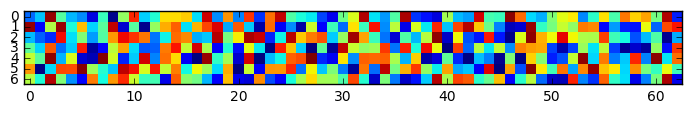

In [6]:
# Set parameters
input_dim = 9
output_dim = 9
n_per_batch = 512
epochs = 100
crop_factor = int(conv_domain/2)
crop_len=crop_factor
filters_per_log = 7

n_convolutions = input_dim*filters_per_log

# Set parameters
conv_dim = 2*input_dim
#hidden_dim_1 = 128
lstm_dim1=18
lstm_dim2=18
lstm_dim3=18
lstm_dim4=9

output_dim = y_train.shape[1]
n_per_batch = 512
epochs = 100
nb_conv1 = input_dim*conv_domain
conv_length=conv_domain
n_conv=input_dim*nb_conv1

init_drop=0.25
lstm_drop=0.5
dense_drop=0.5


def cld_model():
#Input
    inputs=Input(shape=(conv_length,input_dim), name='Input')
#Conv branch    
    x_conv=Dropout(init_drop, name='Dropout_Conv_1')(inputs)    
    x_conv=Convolution1D(nb_conv1, conv_length, border_mode='same', activation='tanh', W_regularizer=l1(0.001), name='Conv1D_1')(x_conv)
    x_conv=Dropout(dense_drop, name='Dropout_Conv_Dense')(x_conv)
    x_conv=Flatten()(x_conv)
    x_conv=Dense(conv_dim, activation='tanh', W_regularizer=l1(0.001), name='Dense1')(x_conv)
    x_conv_in=Reshape((1,conv_dim))(x_conv)

#LSTM branch
    input_lstm=Cropping1D(cropping=(crop_len,crop_len),name='Crop_Input')(inputs)
    #Merge input+conv-branch
    lstm_in=merge([input_lstm,x_conv_in], mode='concat', concat_axis=2)
    x_lstm_1=LSTM(lstm_dim1, return_sequences=True, init='uniform', dropout_W=lstm_drop, dropout_U=lstm_drop, name='LSTM_1')(lstm_in)
    #Merge LSTM1+inputLSTM1
    lstm_in_2=merge([input_lstm,x_lstm_1], mode='concat', concat_axis=2)
    x_lstm_2=LSTM(lstm_dim2, return_sequences=True, init='uniform',dropout_W=lstm_drop, dropout_U=lstm_drop, name='LSTM_2')(lstm_in_2)
    #Merge LSTM2+inputLSTM2
    lstm_in_3=merge([lstm_in_2,x_lstm_2], mode='concat', concat_axis=2)
    x_lstm_3=LSTM(lstm_dim3, return_sequences=True, init='uniform',dropout_W=lstm_drop, dropout_U=lstm_drop, name='LSTM_3')(lstm_in_3)
    #Merge LSTM3+inoutLSTM3
    lstm_in_4=merge([lstm_in_3,x_lstm_3], mode='concat', concat_axis=2)
    x_lstm=LSTM(lstm_dim4, init='uniform', dropout_W=lstm_drop, dropout_U=lstm_drop, name='LSTM_4')(lstm_in_4)

#Fully connected branch
    #input_x=Reshape((input_dim,))(input_lstm)
    input_dense=merge([x_conv,x_lstm], mode='concat', concat_axis=1)
    x_dense=Dropout(dense_drop)(input_dense)
    x_dense=MaxoutDense(36, nb_feature=6, name='MaxoutDense_1')(x_dense)
    out_dense=Dense(9, activation='softmax', name='Output')(x_dense)

#define model
    model=Model(input=inputs, output=out_dense)

#optimizer and compile
    optimizerNadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    model.compile(loss='categorical_crossentropy', optimizer=optimizerNadam, metrics=['accuracy'])
    return model

# Load the model
t0 = time.time()
model_cld = cld_model()
model_cld.summary()
t1 = time.time()
print("Load time = %d" % (t1-t0) )

def plot_weights(n_convs_disp=input_dim):
    layerID=2

    print(model_cld.layers[layerID].get_weights()[0].shape)
    print(model_cld.layers[layerID].get_weights()[1].shape)

    fig, ax = plt.subplots(figsize=(12,10))

    for i in range(n_convs_disp):
        plt.subplot(input_dim,1,i+1)
        plt.imshow(model_cld.layers[layerID].get_weights()[0][:,0,i,:], interpolation='none')

    plt.show()
    
plot_weights(1)

#### We train the CLDNN and evaluate it on precision/recall.

In [7]:
#Train model
t0 = time.time()
model_cld.fit(X_train, y_train, batch_size=n_per_batch, nb_epoch=epochs, verbose=2)
t1 = time.time()
print("Train time = %d seconds" % (t1-t0) )


# Predict Values on Training set
t0 = time.time()
y_predicted = model_cld.predict( X_train , batch_size=n_per_batch, verbose=2)
t1 = time.time()
print("Test time = %d seconds" % (t1-t0) )

# Print Report

# Format output [0 - 8 ]
y_ = np.zeros((len(y_train),1))
for i in range(len(y_train)):
    y_[i] = np.argmax(y_train[i])

y_predicted_ = np.zeros((len(y_predicted), 1))
for i in range(len(y_predicted)):
    y_predicted_[i] = np.argmax( y_predicted[i] )
    
# Confusion Matrix
conf = confusion_matrix(y_, y_predicted_)

def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

# Print Results
print ("\nModel Report")
print ("-Accuracy: %.6f" % ( accuracy(conf) ))
print ("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))
print ("\nConfusion Matrix")
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

Epoch 1/100
0s - loss: 2.6430 - acc: 0.1010
Epoch 2/100
0s - loss: 2.3007 - acc: 0.3274
Epoch 3/100
0s - loss: 1.9966 - acc: 0.4146
Epoch 4/100
0s - loss: 1.8142 - acc: 0.4227
Epoch 5/100
0s - loss: 1.6910 - acc: 0.4524
Epoch 6/100
0s - loss: 1.5764 - acc: 0.4682
Epoch 7/100
0s - loss: 1.5119 - acc: 0.4822
Epoch 8/100
0s - loss: 1.4455 - acc: 0.4977
Epoch 9/100
0s - loss: 1.4022 - acc: 0.4984
Epoch 10/100
0s - loss: 1.3687 - acc: 0.5014
Epoch 11/100
0s - loss: 1.3332 - acc: 0.5065
Epoch 12/100
0s - loss: 1.3125 - acc: 0.5205
Epoch 13/100
0s - loss: 1.3027 - acc: 0.5154
Epoch 14/100
0s - loss: 1.2771 - acc: 0.5326
Epoch 15/100
1s - loss: 1.2608 - acc: 0.5245
Epoch 16/100
1s - loss: 1.2541 - acc: 0.5311
Epoch 17/100
0s - loss: 1.2402 - acc: 0.5318
Epoch 18/100
1s - loss: 1.2395 - acc: 0.5257
Epoch 19/100
1s - loss: 1.2145 - acc: 0.5370
Epoch 20/100
1s - loss: 1.2099 - acc: 0.5424
Epoch 21/100
1s - loss: 1.2132 - acc: 0.5343
Epoch 22/100
1s - loss: 1.2027 - acc: 0.5281
Epoch 23/100
0s - l

#### We display the learned 1D convolution kernels

(7, 1, 9, 63)
(63,)


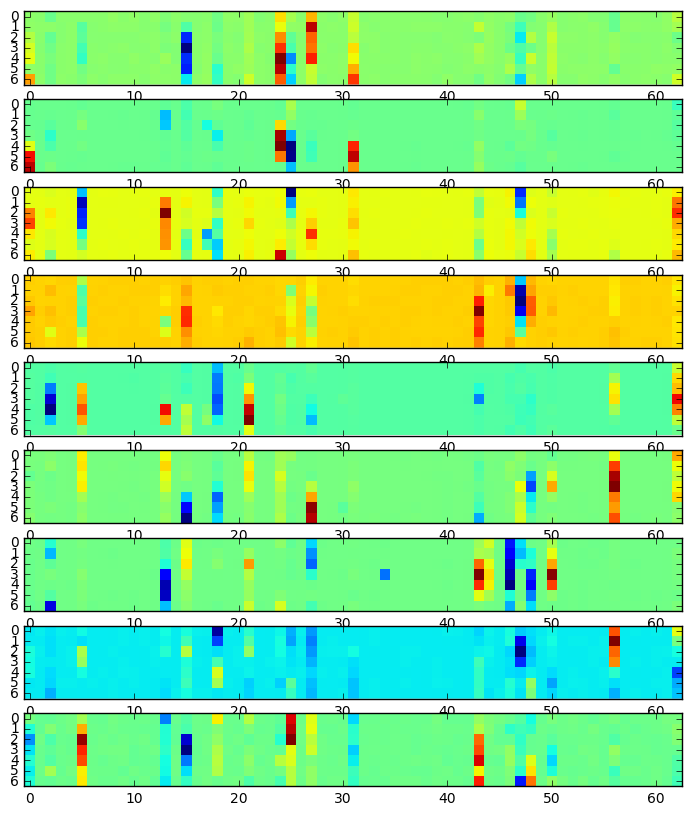

In [8]:
plot_weights()

#### In order to avoid overfitting, we evaluate our model by running a 5-fold stratified cross-validation routine.

In [ ]:
# Cross Validation
def cross_validate():
    t0 = time.time()
    estimator = KerasClassifier(build_fn=cld_model, nb_epoch=epochs, batch_size=n_per_batch, verbose=0)
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    results_cld = cross_val_score(estimator, X_train, y_train, cv= skf.get_n_splits(X_train, y_train))
    t1 = time.time()
    print("Cross Validation time = %d" % (t1-t0) )
    print(' Cross Validation Results')
    print( results_cld )
    print(np.mean(results_cld))

cross_validate()

## Prediction
---
To predict the STUART and CRAWFORD blind wells we do the following:

#### Set up a plotting function to display the logs & facies.

In [9]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

def make_facies_log_plot(logs, facies_colors, y_test=None, wellId=None):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()

    facies = np.zeros(2*(int(zbot-ztop)+1))
    
    shift = 0
    depth = ztop
    for i in range(logs.Depth.count()-1):
        while (depth < logs.Depth.values[i] + 0.25 and depth < zbot+0.25):
            if (i<logs.Depth.count()-1):
                new = logs['Facies'].values[i]
                facies[shift] = new
                depth += 0.5
                shift += 1
    facies = facies[0:facies.shape[0]-1]
    cluster=np.repeat(np.expand_dims(facies,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=8, gridspec_kw={'width_ratios':[1,1,1,1,1,1,2,2]}, figsize=(10, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    ax[5].plot(logs.NM_M, logs.Depth, '-', color='black')
    
    if (y_test is not None):
        for i in range(9):
            if (wellId == 'STUART'):
                ax[6].plot(y_test[0:474,i], logs.Depth, color=facies_colors[i], lw=1.5)
            else:
                ax[6].plot(y_test[474:,i], logs.Depth, color=facies_colors[i], lw=1.5)
                
    im=ax[7].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=5)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel("NM_M")
    ax[5].set_xlim(logs.NM_M.min()-1.,logs.NM_M.max()+1.)
    ax[6].set_xlabel("Facies Prob")
    ax[6].set_xlim(0.0,1.0)
    ax[7].set_xlabel('Facies')
    
    ax[0].set_yticklabels([]);
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[6].set_xticklabels([]); ax[7].set_xticklabels([]);
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    


#### Run the model on the blind data
 - Output a CSV
 - Plot the wells in the notebook

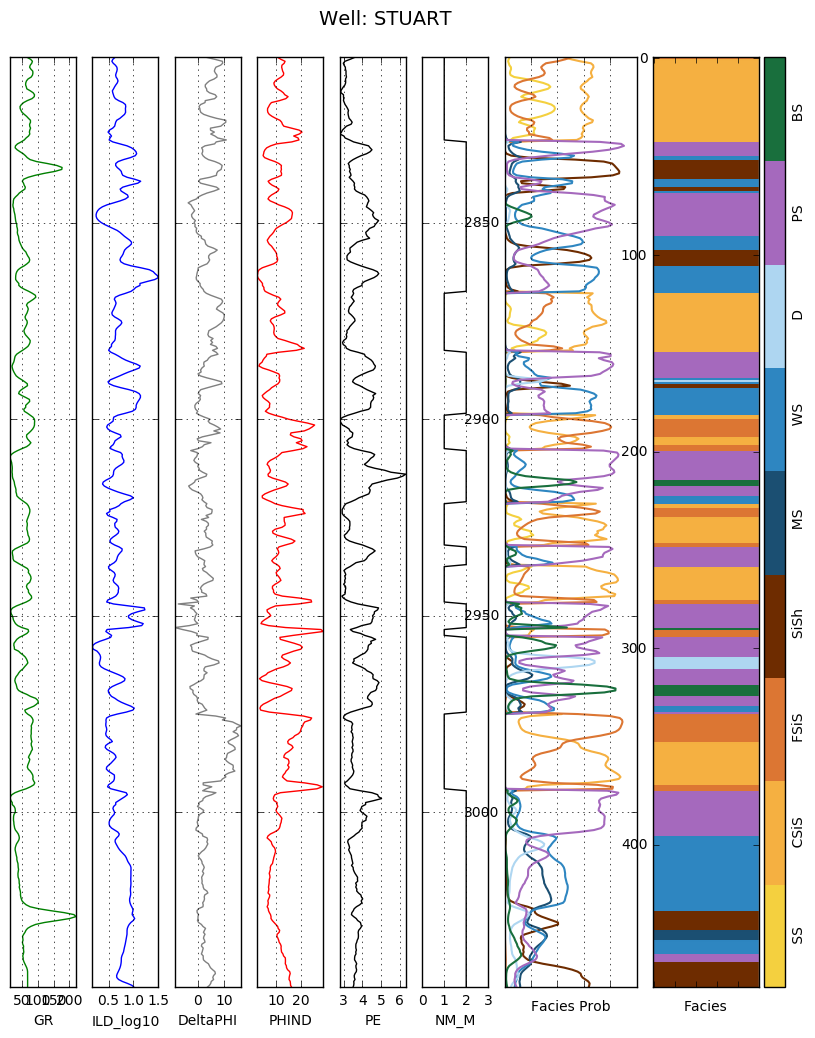

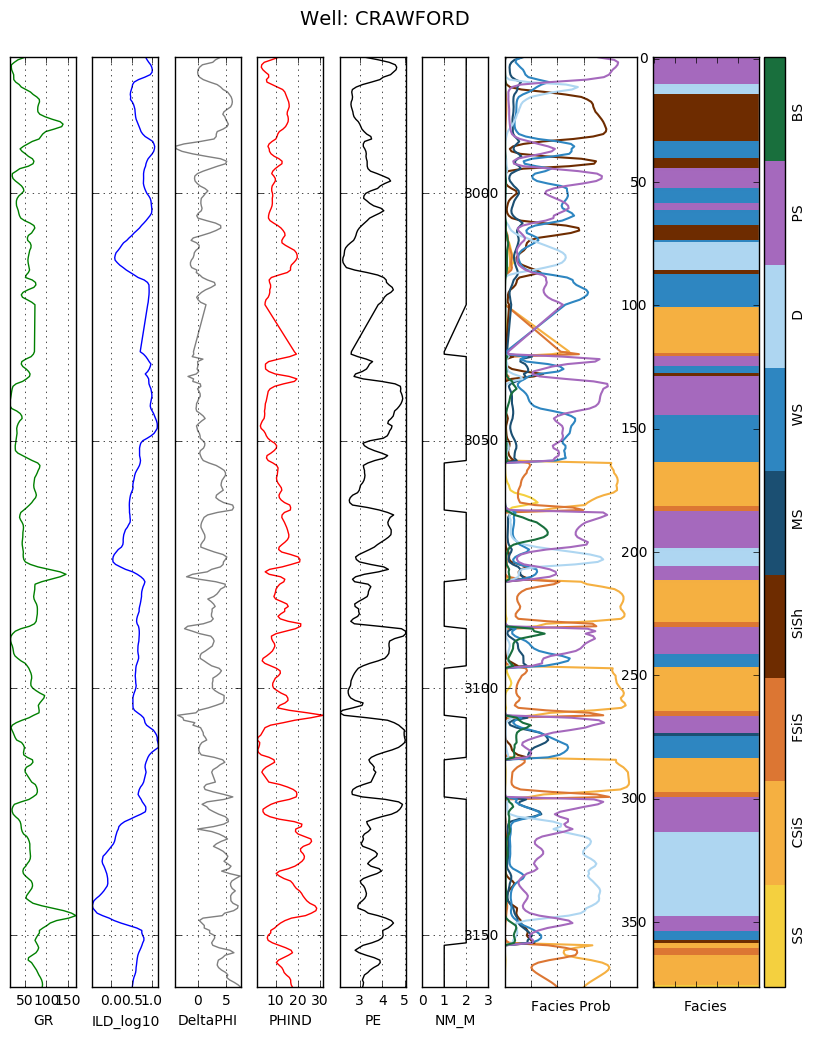

In [10]:
# CLDNN model Prediction
y_test = model_cld.predict( X_test , batch_size=n_per_batch, verbose=0)
predictions_cld = np.zeros((len(y_test),1))
for i in range(len(y_test)):
    predictions_cld[i] = np.argmax(y_test[i]) + 1 
predictions_cld = predictions_cld.astype(int)
# Store results
train_data = pd.read_csv('train_test_data.csv')
test_data = pd.read_csv('../validation_data_nofacies.csv')
test_data['Facies'] = predictions_cld
test_data.to_csv('Prediction_StoDIG_5.csv')


for wellId in well_names_validate:
    make_facies_log_plot( test_data[test_data['Well Name'] == wellId], facies_colors=facies_colors, y_test=y_test, wellId=wellId)
    
#for wellId in well_names_test:
#    make_facies_log_plot( train_data[train_data['Well Name'] == wellId], facies_colors=facies_colors)